# Semantic Segmentation

Using the videos and photos taken from dash cams, we can see front view of a car driving along the road in a city or countryside. In this project, we build a semantic segmentation model using image set from Kaggle

## About the dataset
The dataset is taken from Kaggle: Semantic Segmentation for Self Driving Cars. The dataset contains sets of RGB images and corresponding semantic segments  of 5 x 1000 images with labels.

## About the model
Using the concept of Unet, the segmentation is implemented


In [13]:
import numpy as np
import os
import pandas as pd
import imageio as iio
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
%matplotlib inline

In [14]:
path = 'data/dataA/dataA/'
image_path = os.path.join(path, 'CameraRGB/')
mask_path = os.path.join(path, 'CameraSeg/')

image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list[:5]

['F66-51.png', 'F9-60.png', '07_00_181.png', '02_00_030.png', '10_00_230.png']

In [15]:
image_list = [image_path + i for i in image_list]
mask_list = [mask_path + i for i in mask_list]
image_list[:5]

['data/dataA/dataA/CameraRGB/F66-51.png',
 'data/dataA/dataA/CameraRGB/F9-60.png',
 'data/dataA/dataA/CameraRGB/07_00_181.png',
 'data/dataA/dataA/CameraRGB/02_00_030.png',
 'data/dataA/dataA/CameraRGB/10_00_230.png']

In [16]:
image_list = sorted(image_list)
mask_list = sorted(mask_list)
print(f"total images: {len(image_list)}")
image_list[:5]

total images: 1000


['data/dataA/dataA/CameraRGB/02_00_000.png',
 'data/dataA/dataA/CameraRGB/02_00_001.png',
 'data/dataA/dataA/CameraRGB/02_00_010.png',
 'data/dataA/dataA/CameraRGB/02_00_011.png',
 'data/dataA/dataA/CameraRGB/02_00_020.png']

(600, 800, 3)
(600, 800, 3)


Text(0.5, 1.0, 'Mask')

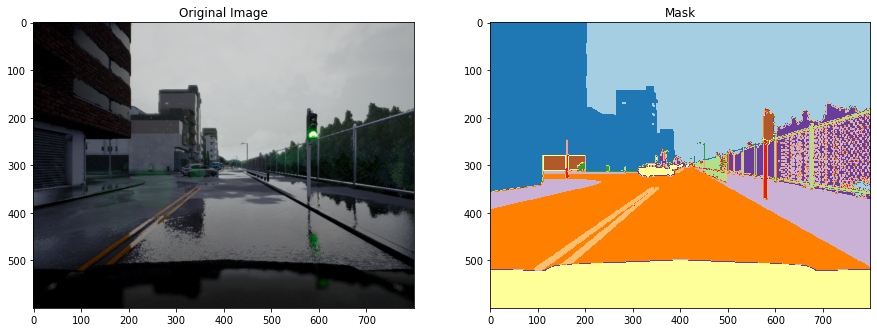

In [17]:
index = 12
img = iio.v3.imread(image_list[index])
print(img.shape)
mask = iio.v3.imread(mask_list[index])
print(mask.shape)

mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1,2,figsize=(15,10))
arr[0].imshow(img)
arr[0].set_title('Original Image')
arr[1].imshow(mask, cmap='Paired')
arr[1].set_title('Mask')

In [18]:
image_list_dataset = tf.data.Dataset.list_files(image_list, shuffle = False)
mask_list_dataset = tf.data.Dataset.list_files(mask_list, shuffle= False)

images_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

In [19]:
images_filenames[:5]

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'data/dataA/dataA/CameraRGB/02_00_000.png',
       b'data/dataA/dataA/CameraRGB/02_00_001.png',
       b'data/dataA/dataA/CameraRGB/02_00_010.png',
       b'data/dataA/dataA/CameraRGB/02_00_011.png',
       b'data/dataA/dataA/CameraRGB/02_00_020.png'], dtype=object)>

In [20]:
dataset = tf.data.Dataset.from_tensor_slices((images_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'data/dataA/dataA/CameraRGB/02_00_000.png', shape=(), dtype=string)
tf.Tensor(b'data/dataA/dataA/CameraSeg/02_00_000.png', shape=(), dtype=string)


In [21]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3) #Normalizes to 0 to 1 range
    
    img = tf.image.convert_image_dtype(img,tf.float32)
    
    mask=tf.io.read_file(mask_path)
    mask= tf.image.decode_png(mask,channels=3)
    mask = tf.math.reduce_max(mask, axis=-1,keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96,128), method='nearest')
    input_mask = tf.image.resize(mask,(96,128), method= 'nearest')
    return input_image, input_mask

In [22]:
image_ds = dataset.map(process_path)
print(image_ds)
processed_image_ds = image_ds.map(preprocess)

<MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None))>


## UNet Framework for semantic Segmentation

In [23]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    conv = Conv2D(n_filters, kernel_size=3, activation='relu', padding = 'same', kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(n_filters, kernel_size=3, activation='relu', padding = 'same', kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
    else:
        next_layer = conv
    skip_connections = conv
    
    return next_layer, skip_connections

In [32]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    up = Conv2DTranspose(n_filters,kernel_size=3, strides=(2,2), padding='same')(expansive_input)
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters, kernel_size=3,activation='relu',padding='same',kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    conv = Conv2D(n_filters, kernel_size=3,activation='relu',padding='same',kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    return conv

In [33]:
def unet_model(input_size=(96,128,3), n_filters=32, n_classes=23):
    inputs=Input(input_size)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 4*n_filters)
    cblock4 = conv_block(cblock3[0], 8*n_filters, dropout_prob=0.3)
    cblock5 = conv_block(cblock4[0], 16*n_filters, dropout_prob=0.3, max_pooling=None)
    
    ublock1 = upsampling_block(cblock5[0], cblock4[1], 8*n_filters)
    ublock2 = upsampling_block(ublock1, cblock3[1], 4*n_filters)
    ublock3 = upsampling_block(ublock2, cblock2[1], 2*n_filters)
    ublock4 = upsampling_block(ublock3, cblock1[1], n_filters)
    
    conv10 = Conv2D(n_filters,3,activation='relu',padding='same',kernel_initializer='he_normal')(ublock4)
    conv11 = Conv2D(n_classes, kernel_size=1, padding='same')(conv10)
    model = tf.keras.Model(inputs=inputs, outputs=conv11)
    
    return model

In [34]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height,img_width,num_channels))

In [36]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 96, 128, 32)  896         ['input_3[0][0]']                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 96, 128, 32)  9248        ['conv2d_20[0][0]']              
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 48, 64, 32)  0           ['conv2d_21[0][0]']          

                                                                                                  
Total params: 8,640,471
Trainable params: 8,640,471
Non-trainable params: 0
__________________________________________________________________________________________________


In [37]:
unet.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [38]:
Epochs = 10
Val_subsplits = 5
Buffer_size = 500
Batch_size = 16
processed_image_ds.batch(Batch_size)
train_dataset = processed_image_ds.cache().shuffle(Buffer_size).batch(Batch_size)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=Epochs)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/10


2022-09-04 18:42:37.336915: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-09-04 18:42:37.960829: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-09-04 18:42:37.962041: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-09-04 18:42:37.962052: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-09-04 18:42:37.962091: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

63/63 [==============================] - 9s 63ms/step - loss: 1.8776 - accuracy: 0.4514
Epoch 2/10
63/63 [==============================] - 3s 41ms/step - loss: 0.6769 - accuracy: 0.7647
Epoch 3/10
63/63 [==============================] - 3s 41ms/step - loss: 0.4860 - accuracy: 0.8414
Epoch 4/10
63/63 [==============================] - 3s 41ms/step - loss: 0.4047 - accuracy: 0.8730
Epoch 5/10
63/63 [==============================] - 3s 41ms/step - loss: 0.3421 - accuracy: 0.8940
Epoch 6/10
63/63 [==============================] - 3s 41ms/step - loss: 0.2885 - accuracy: 0.9102
Epoch 7/10
63/63 [==============================] - 3s 41ms/step - loss: 0.2671 - accuracy: 0.9164
Epoch 8/10
63/63 [==============================] - 3s 41ms/step - loss: 0.2444 - accuracy: 0.9230
Epoch 9/10
63/63 [==============================] - 3s 41ms/step - loss: 0.2179 - accuracy: 0.9307
Epoch 10/10
63/63 [==============================] - 3s 41ms/step - loss: 0.2075 - accuracy: 0.9332


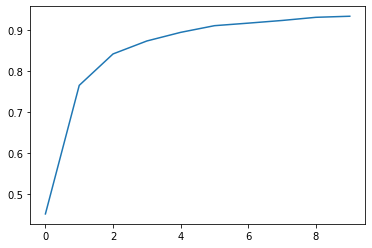

In [39]:
plt.plot(model_history.history["accuracy"])

In [40]:
def display(display_list):
    plt.figure(figsize=(15,15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [42]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis = -1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [45]:
def show_predictions(dataset=None, num=1):
    
    if dataset:
        print("H")
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

H
1/1 [==============================] - 0s 15ms/step


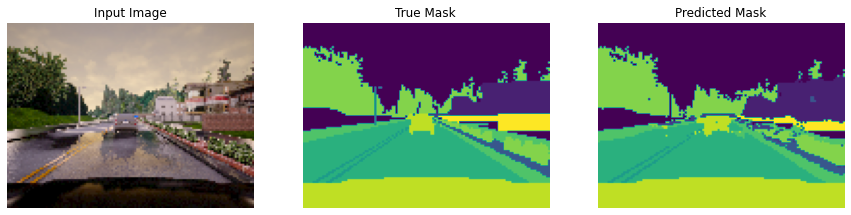

1/1 [==============================] - 0s 15ms/step


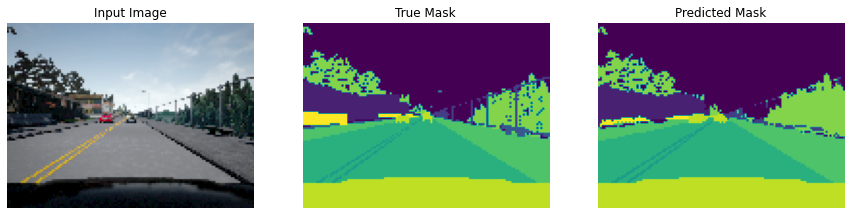

1/1 [==============================] - 0s 16ms/step


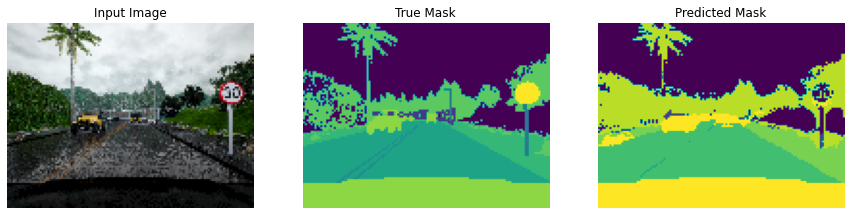

1/1 [==============================] - 0s 17ms/step


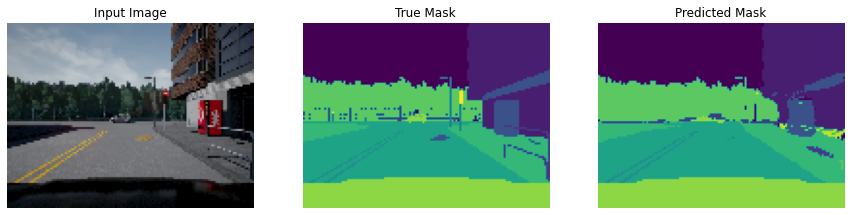

1/1 [==============================] - 0s 15ms/step


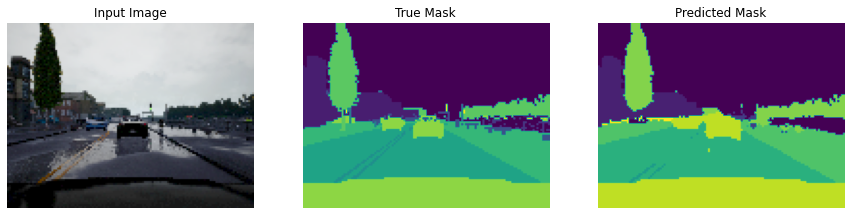

In [46]:
show_predictions(train_dataset, 5)